## Import

In [1]:
import re
import numpy as np 
import matplotlib.pyplot as plt

In [2]:
sentences = """We are about to study the idea of a computational process.
Computational processes are abstract beings that inhabit computers.
As they evolve, processes manipulate other abstract things called data.
The evolution of a process is directed by a pattern of rules
called a program. People create programs to direct processes. In effect,
we conjure the spirits of the computer with our spells."""

In [3]:
sentences = re.sub("[^A-Za-z0-9]",' ',sentences)
sentences = re.sub("(?:^| )\w(?:$| )",' ',sentences).strip().lower()

In [5]:
sentences = re.sub("\s+",' ',sentences)

In [6]:
sentences

'we are about to study the idea of computational process computational processes are abstract beings that inhabit computers as they evolve processes manipulate other abstract things called data the evolution of process is directed by pattern of rules called program people create programs to direct processes in effect we conjure the spirits of the computer with our spells'

In [7]:
words = sentences.split(" ")
vocab = set(words)

In [8]:
len(vocab)

43

In [9]:
vocab_sz = len(vocab)
embed_dim = 10
context_sz = 2

In [23]:
word_idx = {w:i for i,w in enumerate(vocab)}

In [24]:
idx_word = {i:w for w,i in zip(word_idx.keys(),word_idx.values())}

In [26]:
idx_word

{0: 'we',
 1: 'process',
 2: 'processes',
 3: 'manipulate',
 4: 'conjure',
 5: 'evolve',
 6: 'idea',
 7: 'effect',
 8: 'with',
 9: 'spells',
 10: 'are',
 11: 'called',
 12: 'pattern',
 13: 'create',
 14: 'rules',
 15: 'computers',
 16: 'they',
 17: 'of',
 18: 'other',
 19: 'abstract',
 20: 'beings',
 21: 'by',
 22: 'spirits',
 23: 'people',
 24: 'the',
 25: 'directed',
 26: 'our',
 27: 'things',
 28: 'is',
 29: 'inhabit',
 30: 'as',
 31: 'program',
 32: 'in',
 33: 'computer',
 34: 'to',
 35: 'programs',
 36: 'study',
 37: 'that',
 38: 'evolution',
 39: 'about',
 40: 'direct',
 41: 'computational',
 42: 'data'}

In [29]:
data = []
for i in range(2,len(words)-2):
    s = [words[i+j] for j in range(-2,3) if j != 0]
    target = words[i]
    data.append((s,target))

In [30]:
data[:5]

[(['we', 'are', 'to', 'study'], 'about'),
 (['are', 'about', 'study', 'the'], 'to'),
 (['about', 'to', 'the', 'idea'], 'study'),
 (['to', 'study', 'idea', 'of'], 'the'),
 (['study', 'the', 'of', 'computational'], 'idea')]

In [31]:
embeddings = np.random.random_sample(size=(vocab_sz,embed_dim))
print(embeddings.shape)
embeddings

(43, 10)


array([[0.85759487, 0.30661564, 0.63323079, 0.11494084, 0.70141624,
        0.78972387, 0.42538961, 0.67880512, 0.48174031, 0.76995522],
       [0.64723152, 0.68252136, 0.8065137 , 0.98798233, 0.12472958,
        0.59889264, 0.92856751, 0.71417301, 0.26473621, 0.38806543],
       [0.9697622 , 0.67134619, 0.2740989 , 0.93896197, 0.64397462,
        0.3669889 , 0.2430678 , 0.16059562, 0.05703247, 0.80080438],
       [0.7326819 , 0.82552729, 0.2568238 , 0.90893654, 0.26815061,
        0.93561637, 0.42923933, 0.87156435, 0.39714719, 0.37995517],
       [0.67075176, 0.78862229, 0.24559443, 0.53256284, 0.02244754,
        0.2688023 , 0.59129368, 0.97352329, 0.64049318, 0.33688993],
       [0.72318765, 0.6242195 , 0.56713216, 0.07459152, 0.7005349 ,
        0.8702987 , 0.9653974 , 0.42938259, 0.6334754 , 0.66132793],
       [0.09789315, 0.74535834, 0.6615595 , 0.04075233, 0.11570048,
        0.54728447, 0.00130143, 0.79452912, 0.55611606, 0.25503983],
       [0.42983834, 0.4184016 , 0.7133318

In [45]:
def linear(m,theta):
    return m.dot(theta)

In [33]:
def softmax(z):
    e_z = np.exp(z-np.max(z))
    return np.log(e_z / e_z.sum())

In [34]:
def nll(logs,targets):
    out = logs[range(len(targets)),targets]
    return (-out.sum())/len(out)

In [55]:
def crossentropy(logits,target):
    out = np.zeros_like(logits)
    out[np.arange(len(target)),target] = 1
    softmax = np.exp(logits) / np.exp(logits).sum(axis=-1,keepdims=True)
    return (-out + softmax) / logits.shape[0]

In [36]:
def forward(context_idxs, theta):
    m = embeddings[context_idxs].reshape(1, -1)
    n = linear(m, theta)
    o = softmax(n)
    return m, n, o

In [37]:
def backward(preds, theta, target_idxs):
    m, n, o = preds
    dlog = crossentropy(n, target_idxs)
    dw = m.T.dot(dlog)
    return dw

In [38]:
def optimize(theta, grad, lr=0.03):
    theta -= grad * lr
    return theta

In [40]:
theta = np.random.uniform(-1, 1, (2 * context_sz * embed_dim, vocab_sz))

In [42]:
theta.shape

(40, 43)

In [56]:
epoch_losses = {}
for epoch in range(80):
    losses =  []
    for context, target in data:
        context_idxs = np.array([word_idx[w] for w in context])
        preds = forward(context_idxs, theta)
        target_idxs = np.array([word_idx[target]])
        loss = nll(preds[-1], target_idxs)
        losses.append(loss)
        grad = backward(preds, theta, target_idxs)
        theta = optimize(theta, grad, lr=0.03)
    epoch_losses[epoch] = losses

Text(0, 0.5, 'Losses')

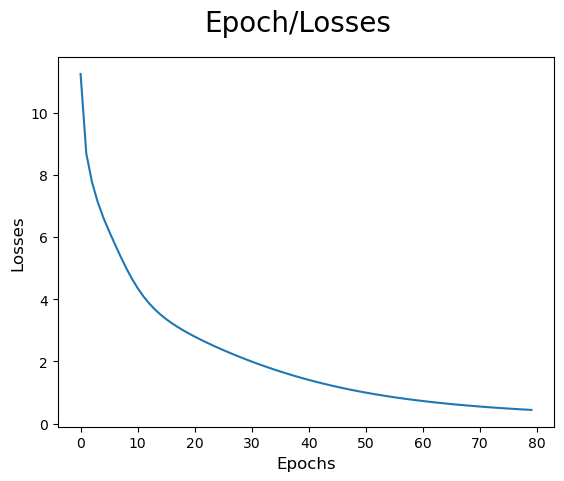

In [57]:
ix = np.arange(0,80)

fig = plt.figure()
fig.suptitle('Epoch/Losses', fontsize=20)
plt.plot(ix,[epoch_losses[i][0] for i in ix])
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Losses', fontsize=12)

In [62]:
def predict(words):
    context_idxs = np.array([word_idx[w] for w in words])
    preds = forward(context_idxs, theta)
    word = idx_word[np.argmax(preds[-1])]
    
    return word

In [63]:
predict(['we', 'are', 'to', 'study'])

'about'

In [64]:
def accuracy():
    wrong = 0

    for context, target in data:
        if(predict(context) != target):
            wrong += 1
            
    return (1 - (wrong / len(data)))

In [65]:
accuracy()

1.0